In [1]:
import pandas as pd

df = pd.read_csv(
    r"C:\Users\kjnav\Documents\Navaneee\Automated-AI-Review-Rating-Prediction-System\data\kaggle\split_dataset_1.csv"
)
print(df.shape)
df['Rating'].value_counts().sort_index()

(810000, 8)


Rating
1    157683
2    151598
3    151712
4    205495
5    143512
Name: count, dtype: int64

In [2]:
df.head(2)

,asin,Review_Text,Rating,Date,Verified_Purchase,Product_Name,Clean_Review,review_length
0,B00CV2M68E,The outer case is very rigid. And it came slig...,2,"12 5, 2014",False,E LV Armor Defender Protective Case for Samsun...,outer case rigid came slightly bowed place dep...,66
1,B005WYYYH4,I realized that I left a review for the phone ...,1,"11 25, 2012",True,Lg Vs700 Enlighten/ls700 Optimus Slider Rubber...,realized left review phone cover cover terribl...,37


In [14]:
duplicate_rows = df[df.duplicated()]
print(f"Total duplicate rows: {len(duplicate_rows)}")

duplicate_reviews = df[df.duplicated(subset='Review_Text')]
print(f"Total duplicate Review_Text entries: {len(duplicate_reviews)}")

Total duplicate rows: 0
Total duplicate Review_Text entries: 0


In [15]:
# Count missing values in each column
missing_counts = df.isnull().sum()
print(missing_counts)

asin                 0
Review_Text          0
Rating               0
Date                 0
Verified_Purchase    0
Product_Name         0
Clean_Review         0
review_length        0
dtype: int64


In [3]:
df['Rating'].value_counts().sort_index()

Rating
1    157683
2    151598
3    151712
4    205495
5    143512
Name: count, dtype: int64

In [4]:
# Desired sample size per rating (except 5 stars)
sample_size = 151598

# Separate 5-star reviews
df_5_star = df[df['Rating'] == 5]

# Downsample other ratings
df_others = df[df['Rating'] != 5].groupby('Rating', group_keys=False).apply(
    lambda x: x.sample(n=sample_size, random_state=42) if len(x) >= sample_size else x
)

# Combine back
df_balanced = pd.concat([df_others, df_5_star]).reset_index(drop=True)

# Check counts
print(df_balanced['Rating'].value_counts())


C:\Users\kjnav\AppData\Local\Temp\ipykernel_17792\3783504494.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_others = df[df['Rating'] != 5].groupby('Rating', group_keys=False).apply(


Rating
1    151598
2    151598
3    151598
4    151598
5    143512
Name: count, dtype: int64


In [5]:
df = df_balanced.sample(frac=1).reset_index(drop=True)

In [6]:
import pandas as pd                # data manipulation and analysis
import matplotlib.pyplot as plt    # creating visualizations
import seaborn as sns              # advanced and attractive statistical plots
import re                          # text preprocessing like removing special characters, numbers, or patterns from text.
import string                      # Contains string constants and utility functions and used to remove punctuation from text


from sklearn.model_selection import train_test_split, GridSearchCV  
# train_test_split: splits your dataset into training and testing sets to evaluate model performance.
# GridSearchCV: performs hyperparameter tuning by testing different parameter combinations to find the best model.

from sklearn.feature_extraction.text import TfidfVectorizer  
# TfidfVectorizer: converts text data into numerical TF-IDF (Term Frequency-Inverse Document Frequency) features,
# which represent how important a word is in a document relative to the entire dataset.

from sklearn.naive_bayes import MultinomialNB  
# MultinomialNB: Naive Bayes classifier commonly used for text classification tasks such as sentiment analysis.

from sklearn.linear_model import LogisticRegression  
# LogisticRegression: a simple but effective classification algorithm often used as a baseline for text classification.

from sklearn.svm import LinearSVC  
# LinearSVC: Support Vector Machine (SVM) classifier optimized for linear problems - good for text classification.

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score  
# accuracy_score: measures overall accuracy (percentage of correct predictions).
# classification_report: gives precision, recall, and F1-score for each class.
# confusion_matrix: shows how many items were correctly or incorrectly classified for each class.
# f1_score: harmonic mean of precision and recall — balances false positives and false negatives.


# NLTK (Natural Language Processing) Imports
import nltk  
# nltk: the Natural Language Toolkit, used for text preprocessing (tokenization, lemmatization, etc.)

from nltk.corpus import stopwords, wordnet  
# stopwords: provides lists of common words (like 'the', 'is') to remove from text.
# wordnet: lexical database used to find word meanings and parts of speech (useful for lemmatization).

from nltk.stem import WordNetLemmatizer  
# WordNetLemmatizer: reduces words to their base or dictionary form (e.g., 'running' → 'run').

from nltk.tokenize import word_tokenize  
# word_tokenize: splits sentences into individual words (tokens).

from nltk import pos_tag  
# pos_tag: assigns parts of speech (noun, verb, adjective, etc.) to each word — helps in accurate lemmatization.


In [39]:
# NLTK data
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download("omw-1.4")

In [7]:
# define common negation words that should not be removed
negation_words = {'not', 'no', 'never', "n't", 'cannot'}

# get the default English stop words from nltk
original_stop_words = set(stopwords.words("english"))

# create custom stop words by keeping negation words
custom_stop_words = original_stop_words - negation_words

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# function to handle negations in text
def handle_negation(text):
    # joins negation words with following words, e.g. "not good" to "not_good"
    # only applies to 'not', 'no', 'never', 'n't' as 'cannot' is a single word
    text = re.sub(r"\b(not|no|never|n't)\b\s*(\w+)",
                  r"\1_\2", text, flags=re.IGNORECASE)
    return text

# function to map nltk pos tags to wordnet pos tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# main optimized preprocessing function
def preprocess_optimized(text):
    text = str(text).lower()
    
    #  Handle Negations (before other cleaning)
    text = handle_negation(text)
    
    #  Comprehensive Cleaning
    text = re.sub(r"http\S+|www\S+", "", text)      # Remove URLs
    text = re.sub(r"<.*?>|\n", " ", text)          # Remove HTML tags and newlines
    
    #  Remove non-alphanumeric/non-space (except for underscores from negation handling)
    text = re.sub(r"[^a-z0-9_\s]", "", text)
    
    #  Tokenize
    tokens = word_tokenize(text)
    
    # POS-Tagging and Lemmatization
    pos_tags = pos_tag(tokens)
    
    lemmatized_tokens = []
    for word, pos in pos_tags:
        # Check for stop words and empty strings
        if word not in custom_stop_words and word:
            # Lemmatize
            lemmatized_word = lemmatizer.lemmatize(word, get_wordnet_pos(pos))
            lemmatized_tokens.append(lemmatized_word)

    # Post-Lemmatization Filter: Remove single-character tokens (noise)
    # Allows for special tokens like 'not_good'
    filtered_tokens = [t for t in lemmatized_tokens if len(t) > 1 or '_' in t]
    
    # Join and Final Clean-up
    return " ".join(filtered_tokens).strip()

In [8]:
# Apply preprocessing
df["cleaned_review"] = df["Review_Text"].astype(str).apply(preprocess_optimized)

# Count words in the cleaned review
# df["word_count"] = df["cleaned_review"].apply(lambda x: len(x.split()))


In [9]:
# Remove 'asin' column (inplace modifies the original df)
df.drop('asin', axis=1, inplace=True)
df.head(3)

,Review_Text,Rating,Date,Verified_Purchase,Product_Name,Clean_Review,review_length,cleaned_review
0,Great item. Just as described. Excellent rolle...,5,"06 28, 2015",True,Headphone Adapter for iPhone Jack AUX Audio 3....,great item described excellent roller especial...,21,great item described excellent roller especial...
1,much shorter cords than I thought. But I love...,3,"01 29, 2015",True,Etre Jeune Headphones Adapter 2 in 1 Compatibl...,much shorter cords thought love retractable fu...,12,much short cord think love retractable function
2,Top broke pretty quickly after just a couple w...,2,"12 15, 2016",True,VAKOO iPhone 5 Case Combo 3-in-1 Slim Lightwei...,top broke pretty quickly couple weeks use expe...,15,top break pretty quickly couple week use expec...


In [10]:
df.head(3)

,Review_Text,Rating,Date,Verified_Purchase,Product_Name,Clean_Review,review_length,cleaned_review
0,Great item. Just as described. Excellent rolle...,5,"06 28, 2015",True,Headphone Adapter for iPhone Jack AUX Audio 3....,great item described excellent roller especial...,21,great item described excellent roller especial...
1,much shorter cords than I thought. But I love...,3,"01 29, 2015",True,Etre Jeune Headphones Adapter 2 in 1 Compatibl...,much shorter cords thought love retractable fu...,12,much short cord think love retractable function
2,Top broke pretty quickly after just a couple w...,2,"12 15, 2016",True,VAKOO iPhone 5 Case Combo 3-in-1 Slim Lightwei...,top broke pretty quickly couple weeks use expe...,15,top break pretty quickly couple week use expec...


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt


Clean and Split Data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Drop rows with missing cleaned_review
df = df.dropna(subset=['cleaned_review']).reset_index(drop=True)

X = df['cleaned_review'].astype(str)  # ensure all values are strings
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 2. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words='english',
    sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


#### Naive Bayes


==================== Naive Bayes ====================
Train Accuracy:  0.6820
Train F1-Score:  0.6808
Test Accuracy:  0.6600
Test F1-Score:  0.6586

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.80      0.79     30320
           2       0.57      0.57      0.57     30319
           3       0.55      0.51      0.53     30320
           4       0.61      0.62      0.62     30320
           5       0.79      0.80      0.79     28702

    accuracy                           0.66    149981
   macro avg       0.66      0.66      0.66    149981
weighted avg       0.66      0.66      0.66    149981

[[24367  4303   989   362   299]
 [ 4223 17397  6145  1918   636]
 [ 1614  6112 15477  5941  1176]
 [  807  1855  4817 18911  3930]
 [  541   629   718  3978 22836]]


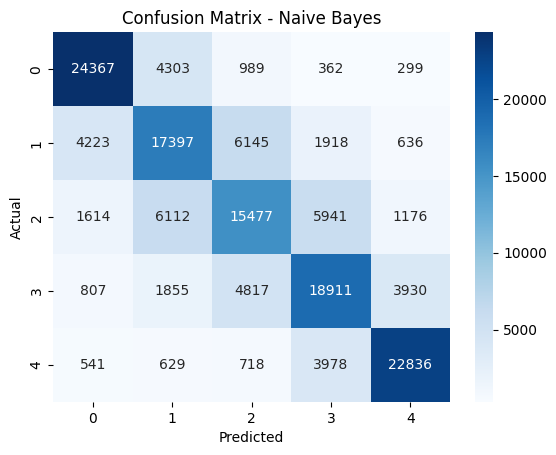

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============ Naive Bayes ============
print(f"\n{'='*20} Naive Bayes {'='*20}")

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_train_pred_nb = nb_model.predict(X_train_tfidf)
y_test_pred_nb = nb_model.predict(X_test_tfidf)

train_acc_nb = accuracy_score(y_train, y_train_pred_nb)
test_acc_nb = accuracy_score(y_test, y_test_pred_nb)
train_f1_nb = f1_score(y_train, y_train_pred_nb, average='weighted')
test_f1_nb = f1_score(y_test, y_test_pred_nb, average='weighted')


print(f"Train Accuracy:  {train_acc_nb:.4f}")
print(f"Train F1-Score:  {train_f1_nb:.4f}")
# print(f"Train Accuracy: {train_acc_nb:.4f}")
print(f"Test Accuracy:  {test_acc_nb:.4f}")
# print(f"Train F1-Score: {train_f1_nb:.4f}")
print(f"Test F1-Score:  {test_f1_nb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_nb))
print(confusion_matrix(y_test, y_test_pred_nb))

cm_nb = confusion_matrix(y_test, y_test_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### Logistic Regression


==================== Logistic Regression ====================


c:\Users\kjnav\anaconda3\envs\reviewenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Train Accuracy for logistic:  0.7162719215632672
Training F1 score for logistic:  0.6926602315752942
Test Accuracy:  0.6963
Test F1-Score:  0.6927

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.83      0.82     30320
           2       0.61      0.63      0.62     30319
           3       0.60      0.51      0.55     30320
           4       0.66      0.66      0.66     30320
           5       0.79      0.86      0.82     28702

    accuracy                           0.70    149981
   macro avg       0.69      0.70      0.69    149981
weighted avg       0.69      0.70      0.69    149981

[[25220  3659   758   378   305]
 [ 4095 19069  4726  1622   807]
 [ 1369  6527 15337  5761  1326]
 [  440  1608  4087 20104  4081]
 [  339   495   635  2538 24695]]


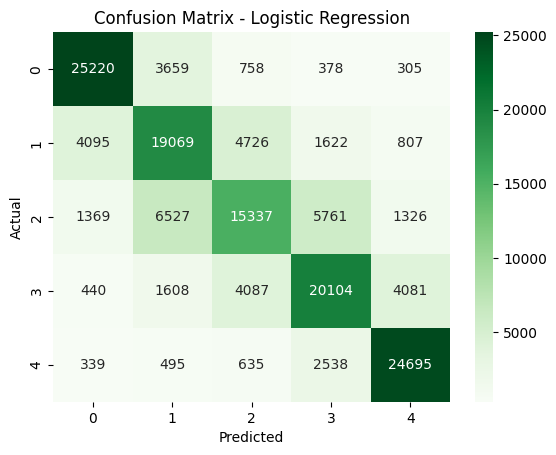

In [26]:
from sklearn.linear_model import LogisticRegression

# ============ Logistic Regression ============
print(f"\n{'='*20} Logistic Regression {'='*20}")

log_model = LogisticRegression(max_iter=1000, solver='liblinear')
log_model.fit(X_train_tfidf, y_train)

y_train_pred_log = log_model.predict(X_train_tfidf)
y_test_pred_log = log_model.predict(X_test_tfidf)

train_acc_log = accuracy_score(y_train, y_train_pred_log)
test_acc_log = accuracy_score(y_test, y_test_pred_log)
train_f1_log = f1_score(y_train, y_train_pred_log, average='weighted')
test_f1_log = f1_score(y_test, y_test_pred_log, average='weighted')


train_acc_log = accuracy_score(y_train, y_train_pred_log)
train_f1_log = f1_score(y_test, y_test_pred_log, average='weighted')
print("Train Accuracy for logistic: ",train_acc_log)
print("Training F1 score for logistic: ",train_f1_log)
# print(f"Train Accuracy: {train_acc_log:.4f}")
print(f"Test Accuracy:  {test_acc_log:.4f}")
# print(f"Train F1-Score: {train_f1_log:.4f}")
print(f"Test F1-Score:  {test_f1_log:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_log))
print(confusion_matrix(y_test, y_test_pred_log))

cm_log = confusion_matrix(y_test, y_test_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


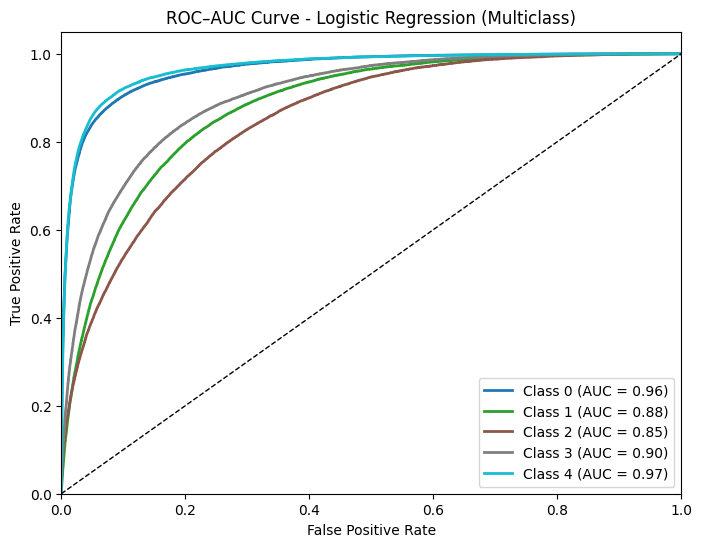


Macro-average ROC–AUC: 0.9126
Micro-average ROC–AUC: 0.9214


In [37]:

# ===== ROC–AUC Curve =====
# Binarize labels for multiclass ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = log_model.predict_proba(X_test_tfidf)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))  # distinct colors

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC–AUC Curve - Logistic Regression (Multiclass)')
plt.legend(loc='lower right')
plt.show()

# ===== Average ROC–AUC =====
macro_roc_auc = roc_auc_score(y_test_bin, y_score, average='macro')
micro_roc_auc = roc_auc_score(y_test_bin, y_score, average='micro')

print(f"\nMacro-average ROC–AUC: {macro_roc_auc:.4f}")
print(f"Micro-average ROC–AUC: {micro_roc_auc:.4f}")

| Class   | Meaning (likely rating) | AUC  | Interpretation                                              |
| ------- | ----------------------- | ---- | ----------------------------------------------------------- |
| Class 0 | e.g., Rating 1-star     | 0.96 | Model predicts 1-star reviews very accurately               |
| Class 1 | e.g., Rating 2-star     | 0.88 | Good discrimination ability                                 |
| Class 2 | e.g., Rating 3-star     | 0.85 | Moderate ability; model confuses 3-star with nearby ratings |
| Class 3 | e.g., Rating 4-star     | 0.90 | Strong performance                                          |
| Class 4 | e.g., Rating 5-star     | 0.97 | Excellent discrimination for 5-star reviews                 |


Performs very well overall, with AUC values mostly above 0.85.

Is best at detecting extreme ratings (1-star and 5-star).

Has slightly lower accuracy for middle ratings (like 3-star)

#### Linear SVM


==================== Linear SVM ====================
Train Accuracy:  0.7202
Train F1-Score:  0.7162
Test Accuracy:  0.6825
Test F1-Score:  0.6777

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.83      0.81     30320
           2       0.59      0.61      0.60     30319
           3       0.59      0.48      0.53     30320
           4       0.64      0.65      0.65     30320
           5       0.78      0.86      0.82     28702

    accuracy                           0.68    149981
   macro avg       0.68      0.68      0.68    149981
weighted avg       0.68      0.68      0.68    149981


Confusion Matrix:
[[25157  3678   743   402   340]
 [ 4509 18395  4692  1829   894]
 [ 1507  6819 14432  6079  1483]
 [  486  1749  3955 19705  4425]
 [  364   484   603  2572 24679]]


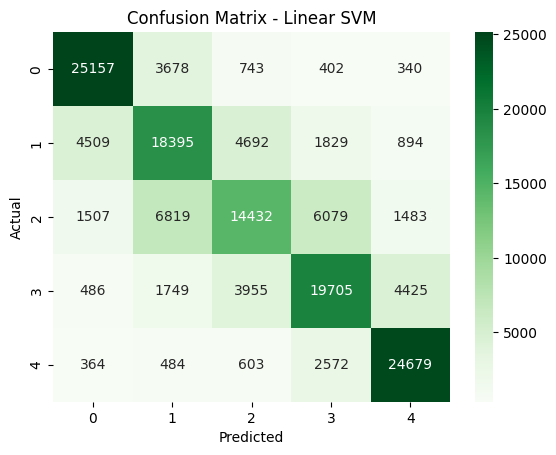

In [28]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============ Linear SVM ============
print(f"\n{'='*20} Linear SVM {'='*20}")

# Initialize the Linear SVM model
svm_model = LinearSVC(random_state=42, C=1.0)  # You can tune C if needed

# Train the model
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_train_pred_svm = svm_model.predict(X_train_tfidf)
y_test_pred_svm = svm_model.predict(X_test_tfidf)

# Metrics
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
train_f1_svm = f1_score(y_train, y_train_pred_svm, average='weighted')
test_f1_svm = f1_score(y_test, y_test_pred_svm, average='weighted')

# Print metrics
print(f"Train Accuracy:  {train_acc_svm:.4f}")
print(f"Train F1-Score:  {train_f1_svm:.4f}")

print(f"Test Accuracy:  {test_acc_svm:.4f}")
print(f"Test F1-Score:  {test_f1_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_svm))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Linear SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### Random Forest


==================== Random Forest ====================
Train Accuracy:  0.9949
Train F1-Score:  0.9949
Test Accuracy:  0.6647
Test F1-Score:  0.6600

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.83      0.79     30320
           2       0.58      0.57      0.57     30319
           3       0.58      0.47      0.52     30320
           4       0.62      0.65      0.64     30320
           5       0.76      0.82      0.78     28702

    accuracy                           0.66    149981
   macro avg       0.66      0.67      0.66    149981
weighted avg       0.66      0.66      0.66    149981


Confusion Matrix:
[[25034  3723   743   407   413]
 [ 5102 17214  4804  2087  1112]
 [ 1606  6323 14342  6297  1752]
 [  616  1806  3930 19671  4297]
 [  501   839   844  3087 23431]]


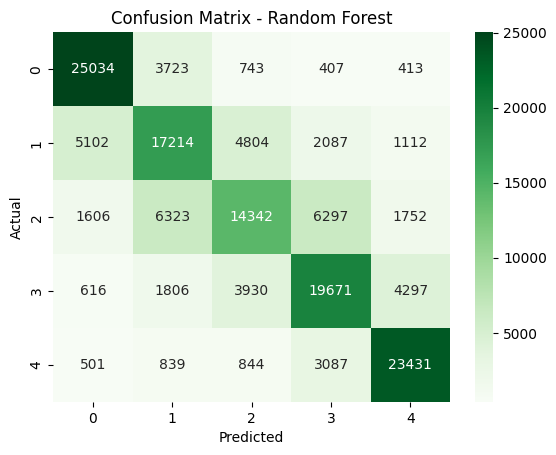

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============ Random Forest ============ 
print(f"\n{'='*20} Random Forest {'='*20}")

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=None,         # maximum depth of each tree
    random_state=42,
    n_jobs=-1               # use all processors
)

# Fit the model
rf_model.fit(X_train_tfidf, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_tfidf)
y_test_pred_rf = rf_model.predict(X_test_tfidf)

# Accuracy & F1 Score
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
train_f1_rf = f1_score(y_train, y_train_pred_rf, average='weighted')
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')

# Print results
print(f"Train Accuracy:  {train_acc_rf:.4f}")
print(f"Train F1-Score:  {train_f1_rf:.4f}")

print(f"Test Accuracy:  {test_acc_rf:.4f}")
print(f"Test F1-Score:  {test_f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [30]:
# ==============================
# 1. Split Data
# ==============================
X = df['cleaned_review']
y = df['Rating'] - 1   #  Convert [1–5] → [0–4]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==============================
# 2. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(
    max_features=20000,
    stop_words='english',
    sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (599923, 20000) (149981, 20000)


#### LightGBM


==================== LightGBM ====================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 17.327878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385273
[LightGBM] [Info] Number of data points in the train set: 599923, number of used features: 10545
[LightGBM] [Info] Start training from score -1.598716
[LightGBM] [Info] Start training from score -1.598708
[LightGBM] [Info] Start training from score -1.598716
[LightGBM] [Info] Start training from score -1.598716
[LightGBM] [Info] Start training from score -1.653523


c:\Users\kjnav\anaconda3\envs\reviewenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kjnav\anaconda3\envs\reviewenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train Accuracy:  0.6757
Train F1-Score:  0.6735
Test Accuracy:  0.6682
Test F1-Score:  0.6659

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     30320
           1       0.56      0.61      0.59     30319
           2       0.59      0.49      0.53     30320
           3       0.63      0.65      0.64     30320
           4       0.76      0.81      0.78     28702

    accuracy                           0.67    149981
   macro avg       0.67      0.67      0.67    149981
weighted avg       0.67      0.67      0.67    149981


Confusion Matrix:
[[24013  4683   767   529   328]
 [ 4025 18517  4682  2032  1063]
 [ 1297  6471 14727  6164  1661]
 [  476  1889  4011 19777  4167]
 [  471  1219   860  2969 23183]]


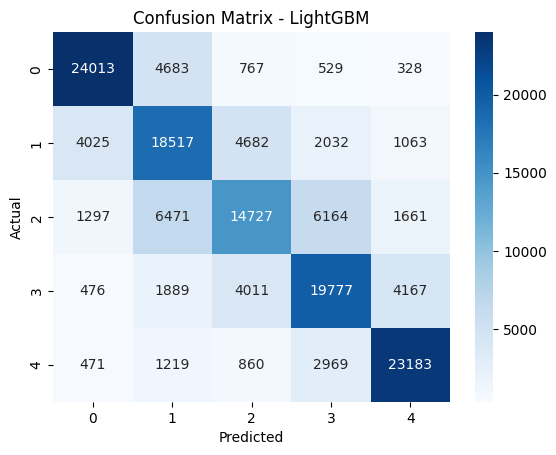

In [31]:
from lightgbm import LGBMClassifier

# ============ LightGBM ============
print(f"\n{'='*20} LightGBM {'='*20}")

lgb_model = LGBMClassifier(random_state=42)

lgb_model.fit(X_train_tfidf, y_train)

y_train_pred_lgb = lgb_model.predict(X_train_tfidf)
y_test_pred_lgb = lgb_model.predict(X_test_tfidf)

train_acc_lgb = accuracy_score(y_train, y_train_pred_lgb)
test_acc_lgb = accuracy_score(y_test, y_test_pred_lgb)
train_f1_lgb = f1_score(y_train, y_train_pred_lgb, average='weighted')
test_f1_lgb = f1_score(y_test, y_test_pred_lgb, average='weighted')

print(f"Train Accuracy:  {train_acc_lgb:.4f}")
print(f"Train F1-Score:  {train_f1_lgb:.4f}")

print(f"Test Accuracy:  {test_acc_lgb:.4f}")
print(f"Test F1-Score:  {test_f1_lgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_lgb))

cm_lgb = confusion_matrix(y_test, y_test_pred_lgb)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### XGBoost


==================== XGBoost ====================


c:\Users\kjnav\anaconda3\envs\reviewenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy:  0.6763
Train F1-Score:  0.6743
Test Accuracy:  0.6562
Test F1-Score:  0.6540

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78     30320
           1       0.55      0.61      0.58     30319
           2       0.58      0.47      0.52     30320
           3       0.62      0.64      0.63     30320
           4       0.76      0.79      0.77     28702

    accuracy                           0.66    149981
   macro avg       0.66      0.66      0.66    149981
weighted avg       0.66      0.66      0.65    149981


Confusion Matrix:
[[23675  5131   699   509   306]
 [ 4148 18597  4481  2057  1036]
 [ 1481  6801 14262  6085  1691]
 [  657  2088  4165 19259  4151]
 [  673  1462   937  3007 22623]]


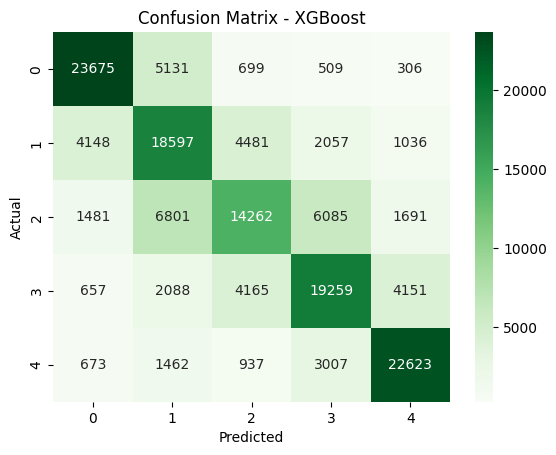

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============ XGBoost ============
print(f"\n{'='*20} XGBoost {'='*20}")

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train_tfidf, y_train)

y_train_pred_xgb = xgb_model.predict(X_train_tfidf)
y_test_pred_xgb = xgb_model.predict(X_test_tfidf)

train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
train_f1_xgb = f1_score(y_train, y_train_pred_xgb, average='weighted')
test_f1_xgb = f1_score(y_test, y_test_pred_xgb, average='weighted')

print(f"Train Accuracy:  {train_acc_xgb:.4f}")
print(f"Train F1-Score:  {train_f1_xgb:.4f}")

print(f"Test Accuracy:  {test_acc_xgb:.4f}")
print(f"Test F1-Score:  {test_f1_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()





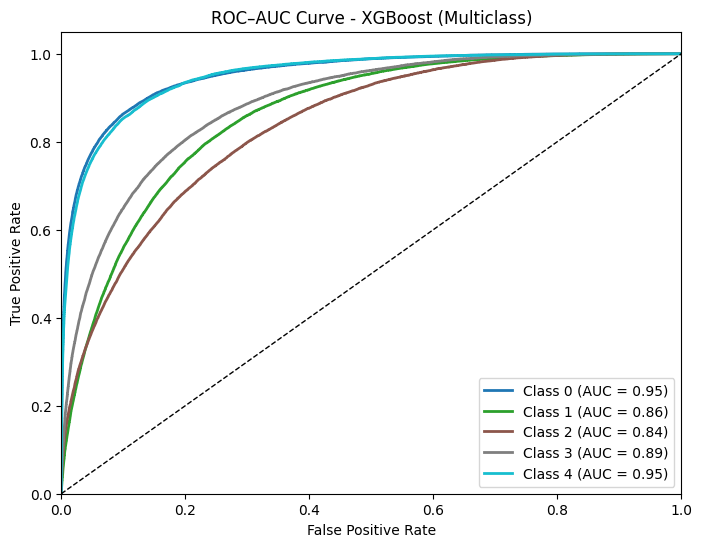


Macro-average ROC–AUC: 0.8972
Micro-average ROC–AUC: 0.9041


In [36]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np
from sklearn.preprocessing import label_binarize

# ===== ROC–AUC Curve =====
# Binarize labels for multiclass ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = xgb_model.predict_proba(X_test_tfidf)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))  # distinct colors

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC–AUC Curve - XGBoost (Multiclass)')
plt.legend(loc='lower right')
plt.show()

# ===== Average ROC–AUC =====
macro_roc_auc = roc_auc_score(y_test_bin, y_score, average='macro')
micro_roc_auc = roc_auc_score(y_test_bin, y_score, average='micro')

print(f"\nMacro-average ROC–AUC: {macro_roc_auc:.4f}")
print(f"Micro-average ROC–AUC: {micro_roc_auc:.4f}")

#### Performance Summary

| Model                   | Train Acc | Test Acc  | Test F1   | **Overfitting %** | Notes                                                               |
| ----------------------- | --------- | --------- | --------- | ----------------: | ------------------------------------------------------------------- |
| **Naive Bayes**         | 0.682     | 0.660     | 0.659     |         **3.23%** | Slight underfit; limited complexity but stable.                     |
| **Logistic Regression** | 0.716     | **0.696** | **0.693** |         **2.80%** | Best generalization; minimal overfit; well-balanced.                |
| **Linear SVM**          | 0.720     | 0.683     | 0.678     |         **5.14%** | Slight overfit; similar to Logistic Regression but less calibrated. |
| **Random Forest**       | 0.995 | 0.665     | 0.660     |     **33.43%**    | Extreme overfitting; memorizing training data.                      |
| **LightGBM**            | 0.676     | 0.668     | 0.666     |         **1.18%** | Very stable; minor underfit; needs tuning for gains.                |
| **XGBoost**             | 0.676     | 0.656     | 0.654     |         **2.96%** | Slight underfit; weaker generalization than LightGBM.               |


| Model                   | Observation                                                                                                                            |
| ----------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Naive Bayes**         | Slight underfit; simple assumption (feature independence) limits its capacity.                                                         |
| **Logistic Regression** | Balanced fit; minor overfit but acceptable.                                                                                            |
| **Linear SVM**          | Slight overfit; similar to logistic but less probability calibration.                                                                  |
| **Random Forest**       | Massive overfit (train 99% vs test 66%); too flexible for sparse text.                                                                 |
| **LightGBM / XGBoost**  | Slight underfit - boosting struggles with high-dimensional sparse TF-IDF features unless tuned carefully (learning rate, depth, etc.). |


- Across all models:
Ratings 1 and 5 : high precision/recall (easy to distinguish - strong sentiment polarity).
Ratings 2, 3, and 4 : frequent confusion.

- For almost all models:
2 ↔ 3 and 3 ↔ 4 show strong overlap.
Recall for 3 is particularly low (0.47–0.51) : most misclassified.

#### Improve model robustness via weighting, cross-validation, and tuning

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=30000,      # try increasing slightly
    stop_words='english',
    sublinear_tf=True,
    ngram_range=(1, 2),
    min_df=4,                # ignore very rare terms
    max_df=0.8               # ignore overly common ones
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (599923, 30000)


In [46]:
vectorizer = TfidfVectorizer(
    max_features=30000,
    stop_words='english',
    sublinear_tf=True,
    ngram_range=(1, 2),
    min_df=5,          # slightly higher to filter rare typos
    max_df=0.8,
    lowercase=True,
    token_pattern = r'\b[a-zA-Z0-9]{2,}\b' # ignore single-letter junk
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (599923, 30000)


In [51]:
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import f1_score
from tqdm import tqdm

# Ignore FutureWarnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

# ==============================
# Sampling (for faster tuning)
# ==============================
sample_size = 100000  # adjust as needed
sample_idx = np.random.choice(len(y_train), sample_size, replace=False)
X_train_sample = X_train_tfidf[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

# ==============================
# Cross-validation setup
# ==============================
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ==============================
# Parameter grid
# ==============================
param_grid = {
    'C': [0.1, 1, 3],
    'penalty': ['l2'],
    'solver': ['saga'],  # fastest & supports l1/l2
    'max_iter': [1000],
    'class_weight': ['balanced']
}

# ==============================
# Manual Grid Search with tqdm
# ==============================
param_list = list(ParameterGrid(param_grid))
results = []
best_score = -1
best_params = None

for params in tqdm(param_list, desc="Tuning Logistic Regression", ncols=100):
    model = LogisticRegression(**params)
    f1_scores = []

    # 3-fold CV
    for train_idx, val_idx in cv.split(X_train_sample, y_train_sample):
        X_tr, X_val = X_train_sample[train_idx], X_train_sample[val_idx]
        y_tr, y_val = y_train_sample.iloc[train_idx], y_train_sample.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1_scores.append(f1_score(y_val, preds, average='macro'))

    mean_f1 = np.mean(f1_scores)
    results.append((params, mean_f1))

    # Live best tracking
    if mean_f1 > best_score:
        best_score = mean_f1
        best_params = params
        print(f"\n New Best: F1={best_score:.4f} | Params={best_params}")

print("\n Final Best Parameters:", best_params)
print(f" Best CV Macro-F1: {best_score:.4f}")


Tuning Logistic Regression:  33%|████████████▎                        | 1/3 [00:06<00:12,  6.07s/it]


 New Best: F1=0.6576 | Params={'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


Tuning Logistic Regression:  67%|████████████████████████▋            | 2/3 [00:13<00:06,  6.70s/it]


 New Best: F1=0.6802 | Params={'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


Tuning Logistic Regression: 100%|█████████████████████████████████████| 3/3 [00:21<00:00,  7.06s/it]


 Final Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
 Best CV Macro-F1: 0.6802


In [52]:

# Ignore FutureWarnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

# ==============================
# Sampling (for faster tuning)
# ==============================
sample_size = 100000  # adjust as needed
sample_idx = np.random.choice(len(y_train), sample_size, replace=False)
X_train_sample = X_train_tfidf[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

# ==============================
# Cross-validation setup
# ==============================
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ==============================
# Parameter grid (earlier)
# ==============================
# param_grid = {
#     'C': [0.1, 1, 3],
#     'penalty': ['l2'],
#     'solver': ['saga'],  # fastest & supports l1/l2
#     'max_iter': [1000],
#     'class_weight': ['balanced']
# }

param_grid = {
    'C': [0.5, 1, 2, 3],
    'penalty': ['l2'],
    'solver': ['saga'],
    'class_weight': ['balanced']
}

# ==============================
# Manual Grid Search with tqdm
# ==============================
param_list = list(ParameterGrid(param_grid))
results = []
best_score = -1
best_params = None

for params in tqdm(param_list, desc="Tuning Logistic Regression", ncols=100):
    model = LogisticRegression(**params)
    f1_scores = []

    # 3-fold CV
    for train_idx, val_idx in cv.split(X_train_sample, y_train_sample):
        X_tr, X_val = X_train_sample[train_idx], X_train_sample[val_idx]
        y_tr, y_val = y_train_sample.iloc[train_idx], y_train_sample.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1_scores.append(f1_score(y_val, preds, average='macro'))

    mean_f1 = np.mean(f1_scores)
    results.append((params, mean_f1))

    # Live best tracking
    if mean_f1 > best_score:
        best_score = mean_f1
        best_params = params
        print(f"\n New Best: F1={best_score:.4f} | Params={best_params}")

print("\n Final Best Parameters:", best_params)
print(f" Best CV Macro-F1: {best_score:.4f}")


Tuning Logistic Regression:  25%|█████████▎                           | 1/4 [00:06<00:19,  6.65s/it]


 New Best: F1=0.6781 | Params={'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}


Tuning Logistic Regression:  50%|██████████████████▌                  | 2/4 [00:13<00:13,  6.61s/it]


 New Best: F1=0.6791 | Params={'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}


Tuning Logistic Regression: 100%|█████████████████████████████████████| 4/4 [00:28<00:00,  7.11s/it]


 Final Best Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
 Best CV Macro-F1: 0.6791


## Linear SVC hyperparameter tuning.

Why Linear Kernel?

Text data has hundreds of thousands of sparse TF-IDF features

Linear kernel SVM is much faster and works better for text than RBF

RBF kernel on TF-IDF is extremely slow and usually performs worse

LinearSVC is equivalent to SVM with kernel='linear' (but faster & scalable)

model is:

✔ Linear SVM
✔ Hinge loss
✔ One-vs-rest classification
✔ Linear decision boundaries

In [17]:
import numpy as np
import warnings
from tqdm import tqdm
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore", category=FutureWarning)


# ================================================
# 1. Train-Test Split
# ================================================
X = df['cleaned_review'].astype(str)
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# ================================================
# 2. TF-IDF Vectorization (WORD)
# ================================================
tfidf_word = TfidfVectorizer(
    max_features=100000,          # increased from 30k → MUCH better
    stop_words='english',
    sublinear_tf=True,
    ngram_range=(1, 2),
    min_df=4,
    max_df=0.8
)

X_train_word = tfidf_word.fit_transform(X_train)
X_test_word = tfidf_word.transform(X_test)


# ================================================
# 3. TF-IDF Vectorization (CHARACTER)
# ================================================
tfidf_char = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    min_df=10,
    max_features=50000
)

X_train_char = tfidf_char.fit_transform(X_train)
X_test_char = tfidf_char.transform(X_test)


# ================================================
# 4. Combine Word + Char Features
# ================================================
X_train_full = hstack([X_train_word, X_train_char])
X_test_full = hstack([X_test_word, X_test_char])

print("Final TF-IDF Shape:", X_train_full.shape)


# ================================================
# 5. Sampling for Tuning (100k)
# ================================================
sample_size = 100000
sample_idx = np.random.choice(X_train_full.shape[0], sample_size, replace=False)

X_train_sample = X_train_full[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

print("Sample shape:", X_train_sample.shape)


# ================================================
# 6. Cross-validation setup
# ================================================
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


# ================================================
# 7. Parameter Grid for Linear SVM
# ================================================
param_grid = {
    'C': [0.5, 1, 1.5, 2.0]
}

param_list = list(ParameterGrid(param_grid))
best_score = -1
best_params = None
results = []


# ================================================
# 8. Manual Grid Search with tqdm
# ================================================
for params in tqdm(param_list, desc="Tuning Linear SVM", ncols=100):

    model = LinearSVC(
        C=params['C'],
        class_weight='balanced'
    )

    f1_scores = []

    # 3-fold CV
    for train_idx, val_idx in cv.split(X_train_sample, y_train_sample):
        X_tr, X_val = X_train_sample[train_idx], X_train_sample[val_idx]
        y_tr, y_val = y_train_sample.iloc[train_idx], y_train_sample.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1_scores.append(f1_score(y_val, preds, average='macro'))

    mean_f1 = np.mean(f1_scores)
    results.append((params, mean_f1))

    if mean_f1 > best_score:
        best_score = mean_f1
        best_params = params
        print(f"\n New Best: F1={mean_f1:.4f} | Params={params}")


print("\n Final Best Parameters:", best_params)
print("Best CV Macro-F1:", best_score)


# ================================================
# 9. Train Final Model on Full 810k Dataset
# ================================================
final_model = LinearSVC(
    C=best_params['C'],
    class_weight='balanced'
)

final_model.fit(X_train_full, y_train)

# ================================================
# 10. Evaluate on Test Set
# ================================================
test_preds = final_model.predict(X_test_full)
test_f1 = f1_score(y_test, test_preds, average='macro')

print(f"\n Test Macro-F1: {test_f1:.4f}")


Final TF-IDF Shape: (599923, 150000)
Sample shape: (100000, 150000)


Tuning Linear SVM:  25%|███████████▌                                  | 1/4 [00:47<02:23, 47.68s/it]


 New Best: F1=0.6901 | Params={'C': 0.5}


Tuning Linear SVM: 100%|██████████████████████████████████████████████| 4/4 [06:02<00:00, 90.70s/it]



 Final Best Parameters: {'C': 0.5}
Best CV Macro-F1: 0.6901081037456983

 Test Macro-F1: 0.7309


Linear With hyperparameter tuning

Train size: 599923
Test size : 149981
TF-IDF Shape: (599923, 150000)

================ TRAIN METRICS ================
Train Accuracy:        0.8464
Train Macro F1:        0.8464
Train Weighted F1:     0.8457

================ TEST METRICS ================
Test Accuracy:         0.7061
Test Macro F1:         0.7052
Test Micro F1:         0.7061
Test Weighted F1:      0.7038

================ CLASSIFICATION REPORT ================
              precision    recall  f1-score   support

           1       0.82      0.83      0.82     30320
           2       0.61      0.63      0.62     30319
           3       0.60      0.53      0.56     30320
           4       0.68      0.68      0.68     30320
           5       0.81      0.87      0.84     28702

    accuracy                           0.71    149981
   macro avg       0.70      0.71      0.71    149981
weighted avg       0.70      0.71      0.70    149981



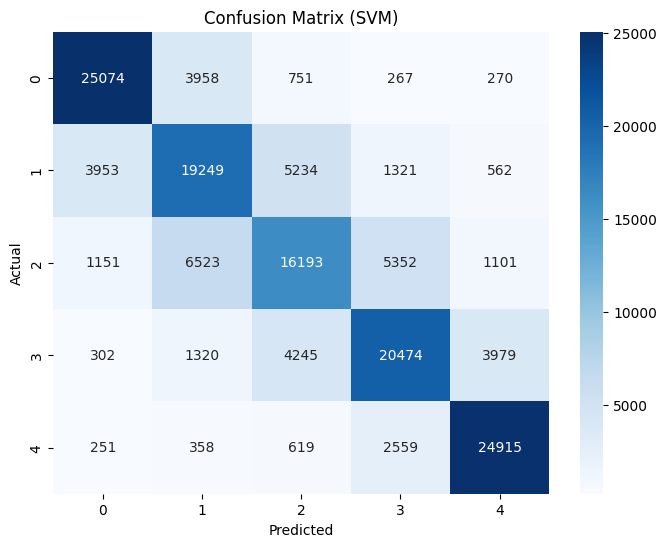


ROC-AUC (macro): 0.9083707510340503


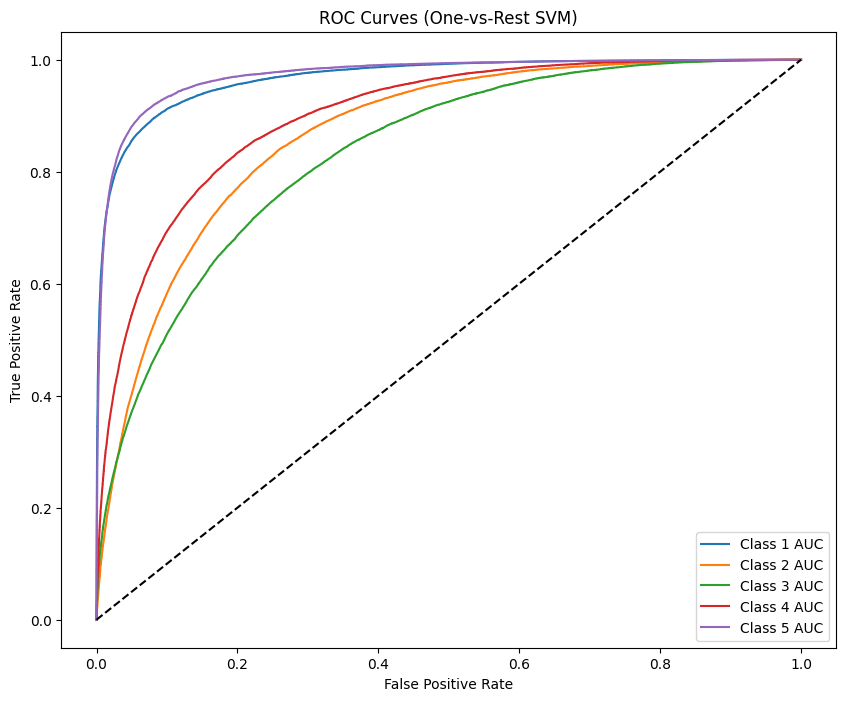


===== Top + Most Negative Features for Class 5 =====

🔼 Top Positive Indicators:
wow = 2.790390345527398
excellent = 2.91017433550841
highly recommend = 2.9699329603891838
highly = 3.008761007493381
fantastic = 3.125139650480087
awesome = 3.135378109190314
lifesaver = 3.142945612211615
not_be disappointed = 3.1619760377732646
perfectly = 3.2646009151023385
zero complaint = 3.2861470727683075
wont disappoint = 3.3036566086786063
perfect = 3.4359205252268286
amaze = 3.4715153559724965
love = 3.986609664213193
best = 4.790939461303438

🔽 Top Negative Indicators:
star = -5.463988100475162
downside = -4.431839454972001
complaint = -4.376062953290107
disappointed = -4.310373669916163
not_fit = -4.180744133173235
wish = -3.9292255777158402
gripe = -3.662827675652549
not_recommend = -3.609493548130243
downfall = -3.4293143473169065
not_work = -3.4194313956219164
not_buy = -3.367746367498496
disappointing = -3.3626687961388106
drawback = -3.323611997104597
overall = -3.2472642595613523
not_the

In [ ]:
# ================================================================
# FULLY COMMENTED LINEAR SVM PIPELINE FOR TEXT CLASSIFICATION
# ================================================================
# Dataset: df with columns:
#   - 'cleaned_review': preprocessed review text
#   - 'Rating': integer ratings (e.g., 1-5)
# Goal: Train Linear SVM on TF-IDF features, evaluate metrics,
#       plot confusion matrix, ROC curves, feature importance,
#       and analyze misclassifications.
# ================================================================

# ---------------------------
# 0. IMPORTS
# ---------------------------
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

# Progress bar
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 1. LOAD DATA
# ---------------------------
# Ensure the dataset df exists in environment
# Columns required: 'cleaned_review' and 'Rating'
# Convert text to string type (important for TF-IDF)
X = df['cleaned_review'].astype(str)
y = df['Rating']  # Ratings should be integer or categorical

# Split into train and test (holdout evaluation)
# 80% training, 20% testing
# stratify=y ensures the distribution of ratings is same in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

# ---------------------------
# 2. TF-IDF VECTORIZATION (WORD LEVEL)
# ---------------------------
# TF-IDF transforms text into numerical vectors
# Word-level TF-IDF captures unigrams and bigrams
vectorizer = TfidfVectorizer(
    max_features=150000,  # Maximum number of features for memory efficiency
    sublinear_tf=True,    # Apply sublinear tf scaling: 1 + log(tf)
    stop_words='english', # Remove common English words
    ngram_range=(1, 2),   # Include unigrams and bigrams
    analyzer='word',      # Word-level analysis
    min_df=4,             # Ignore very rare words
    max_df=0.8            # Ignore very common words
)

# Fit the vectorizer on training data and transform
X_train_tfidf = vectorizer.fit_transform(X_train)
# Transform test data (do not fit again)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF Shape:", X_train_tfidf.shape)

# ---------------------------
# 3. TRAIN LINEAR SVM
# ---------------------------
# LinearSVC is optimized for high-dimensional sparse data (like TF-IDF)
# We set best parameter C=0.5 from your previous cross-validation
model = LinearSVC(
    C=0.5,                # Regularization strength (smaller C = stronger regularization)
    class_weight='balanced' # Adjust weights inversely proportional to class frequencies
)

# Fit the model on training TF-IDF features
model.fit(X_train_tfidf, y_train)

# ---------------------------
# 4. PREDICTIONS
# ---------------------------
# Predict on train and test
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

# ---------------------------
# 5. TRAIN METRICS
# ---------------------------
# Calculate accuracy and F1 scores on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')

print("\n================ TRAIN METRICS ================")
print(f"Train Accuracy:        {train_accuracy:.4f}")
print(f"Train Macro F1:        {train_f1_macro:.4f}")
print(f"Train Weighted F1:     {train_f1_weighted:.4f}")

# ---------------------------
# 6. TEST METRICS
# ---------------------------
# Metrics on holdout test set
test_accuracy = accuracy_score(y_test, y_test_pred)
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
micro_f1 = f1_score(y_test, y_test_pred, average='micro')
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("\n================ TEST METRICS ================")
print(f"Test Accuracy:         {test_accuracy:.4f}")
print(f"Test Macro F1:         {macro_f1:.4f}")
print(f"Test Micro F1:         {micro_f1:.4f}")
print(f"Test Weighted F1:      {weighted_f1:.4f}")

# ---------------------------
# 7. CLASSIFICATION REPORT
# ---------------------------
# Provides per-class precision, recall, F1, and support
print("\n================ CLASSIFICATION REPORT ================")
print(classification_report(y_test, y_test_pred))

# ---------------------------
# 8. CONFUSION MATRIX
# ---------------------------
# Compare true vs predicted labels
cm = confusion_matrix(y_test, y_test_pred)

# Plot as heatmap for easy visualization
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------
# 9. ROC-AUC (MULTICLASS OVR)
# ---------------------------
# LinearSVC does not output probabilities; we use decision_function
# Binarize test labels for multi-class ROC
classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Get decision scores for ROC-AUC
y_scores = model.decision_function(X_test_tfidf)

# Macro-average ROC-AUC across classes
roc_auc = roc_auc_score(y_test_bin, y_scores, average='macro')
print("\nROC-AUC (macro):", roc_auc)

# Plot ROC curves for each class
plt.figure(figsize=(10,8))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f"Class {c} AUC")
plt.plot([0,1], [0,1], 'k--')  # random line
plt.title("ROC Curves (One-vs-Rest SVM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ---------------------------
# 10. FEATURE IMPORTANCE (LINEAR SVM COEFFICIENTS)
# ---------------------------
# LinearSVC coefficients can be interpreted as feature importance
feature_names = np.array(vectorizer.get_feature_names_out())

def show_top_features(class_id, top_n=15):
    """
    Display top positive and negative features for a given class
    """
    coef = model.coef_[class_id]
    top_positive = np.argsort(coef)[-top_n:]  # largest weights
    top_negative = np.argsort(coef)[:top_n]   # smallest weights (negative indicators)

    print(f"\n===== Top + Most Negative Features for Class {classes[class_id]} =====")
    print("\n Top Positive Indicators:")
    for i in top_positive:
        print(feature_names[i], "=", coef[i])
    print("\n Top Negative Indicators:")
    for i in top_negative:
        print(feature_names[i], "=", coef[i])

# Example: show top features for class 5 (index=4)
show_top_features(class_id=4)

# ---------------------------
# 11. ERROR ANALYSIS
# ---------------------------
# Identify misclassified reviews
errors = pd.DataFrame({
    "text": X_test,
    "actual": y_test,
    "predicted": y_test_pred
})
errors = errors[errors["actual"] != errors["predicted"]]

print("\nTotal Misclassified:", len(errors))
# Show first 10 misclassified examples
errors.head(10)

# ---------------------------
# 12. PER-CLASS ACCURACY
# ---------------------------
print("\n=============== PER-CLASS ACCURACY ===============")
for c in classes:
    mask = (y_test == c)
    acc = accuracy_score(y_test[mask], y_test_pred[mask])
    print(f"Rating {c} accuracy: {acc:.4f}")

# ---------------------------
# END OF PIPELINE
# ================================================================
print("\n Pipeline complete. All metrics, plots, and feature analysis generated.")


In [19]:
# ================================================================
# 13. SAVE MODEL AND TOKENIZER
# ================================================================
import joblib
import os

# Define directory to save model and vectorizer
save_dir = r"C:\Users\kjnav\Documents\Navaneee\Automated-AI-Review-Rating-Prediction-System\models"

# Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define file paths
model_path = os.path.join(save_dir, "linear_svm_model.joblib")
vectorizer_path = os.path.join(save_dir, "tfidf_vectorizer.joblib")

# Save the trained Linear SVM model
joblib.dump(model, model_path)
print(f"✅ Model saved at: {model_path}")

# Save the fitted TF-IDF vectorizer
joblib.dump(vectorizer, vectorizer_path)
print(f"✅ TF-IDF vectorizer saved at: {vectorizer_path}")


✅ Model saved at: C:\Users\kjnav\Documents\Navaneee\Automated-AI-Review-Rating-Prediction-System\models\linear_svm_model.joblib
✅ TF-IDF vectorizer saved at: C:\Users\kjnav\Documents\Navaneee\Automated-AI-Review-Rating-Prediction-System\models\tfidf_vectorizer.joblib
